## Final Project Submission

Please fill out:
* Student name: Phillip Ojo
* Student pace: Part-time
* Scheduled project review date/time: Friday, October 16, 6:30 PM EST 
* Instructor name: James Irving
* Blog post URL:


# 1. Introduction

For this project I will use the Traffic, Driving Style and Road Surface Condition Dataset which contains low-level parameters acquired by the cars OBD-II and through the micro-devices embedded in the user smartphone. The aim of this project is to build a classification model that can accurately classify a drivers driving style as "Even Paced" or "Aggressive". Having an effective model is important since it will be tracking the driving behavior in real time to predict if the driver is agressive or not. With the use of this predictive model, a billing or savings strategy can be deployed to auto insurance companies in order to determaine car insurance rates for there drivers based on the driving styles.  

# 2. Import Libraries

In [1]:
%conda install -c conda-forge shap

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer
from sklearn import set_config, metrics
from sklearn.impute import SimpleImputer

#Ensemble classifications models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

#Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report, roc_auc_score,
f1_score, recall_score, precision_score, SCORERS)
import time

# Imbalance, Hyperparameter tunning and pipelines
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#More Feature Importance plots
import shap 
shap.initjs()

# Functions

In [95]:
#Create a function that runs the model of your choice, gives a classification
    #report and plot a confusion matrix and roc curve

def model_evaluation(model, X_test, y_test, X_Train = None , y_Train = None, classes=None,
                           normalize='true',cmap='Purples',label=''):
     
        
    
    
    ## Run Model for Predictions
    y_hat_test = model.predict(X_test)
    
    y_hat_train = model.predict(X_Train)
    

    training_accuracy = accuracy_score(y_Train, y_hat_train)
    testing_accuracy = accuracy_score(y_test, y_hat_test)
    
    print(f'TRAINING ACCURACY: {round(training_accuracy*100,2)}%')
    print(f'TESTING ACCURACY: {round(testing_accuracy*100,2)}%')
    
    ## Classification Report / Scores 
    table_header = "[i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f" {label}"
        
    
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,table_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes+"\n\n")
    
    

    ## MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Plot Roc Curve
    roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()
    
     

# 3. Exploratory Data Analysis

I will combine all the dataset into one large one since my target variable as indepent of specific car model.

In [4]:
df1 = pd.read_csv('opel_corsa_01.csv', delimiter= ';')
df2 = pd.read_csv('opel_corsa_02.csv', delimiter= ';')
df3 = pd.read_csv('peugeot_207_01.csv', delimiter= ';')
df4 = pd.read_csv('peugeot_207_02.csv', delimiter= ';')

In [5]:
all_dfs = [df1, df2, df3, df4]
car_data = pd.concat(all_dfs)

In [6]:
car_data

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage,roadSurface,traffic,drivingStyle
0,NaN,0,NaN,NaN,NaN,"0,0156","25,49019623",64.0,100.0,801,"7,849999905",22.0,"-0,0078",NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
1,NaN,0,NaN,NaN,NaN,"0,0156","25,49019623",64.0,100.0,803,"7,889999866",22.0,"-0,0156",NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
2,NaN,NaN,NaN,NaN,NaN,"0,0273","25,88235283",64.0,100.0,800,"7,769999981",22.0,"-0,0273",NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
3,NaN,NaN,NaN,NaN,NaN,"0,0391","25,88235283",64.0,100.0,798,"7,769999981",22.0,"-0,0273",NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
4,NaN,0,NaN,NaN,NaN,"0,0469","25,88235283",65.0,100.0,798,"7,940000057",22.0,"-0,0312",NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4618,1,"28,79999924","28,55999908","57,19057079","3,600000381","-0,0292","25,88235283",81.0,115.0,"1755,5","20,46999931",25.0,"-0,1661","14,57800293",SmoothCondition,LowCongestionCondition,EvenPaceStyle
4619,"1,699996948","30,59999847","28,5299991","57,01026584","1,799999237","-0,0304","11,76470566",81.0,106.0,"736,5","17,73999977",25.0,"-0,1987","14,58564186",SmoothCondition,LowCongestionCondition,EvenPaceStyle
4620,"1,800003052","29,69999886","28,49999908","56,8830454","-0,899999619","-0,1684","98,03921509",81.0,106.0,1254,"9,520000458",24.0,"-0,1156","14,54729366",SmoothCondition,LowCongestionCondition,EvenPaceStyle
4621,"2,100006104","29,69999886","28,40999908","56,16090993",0,"-0,0644","79,60784149",80.0,112.0,1254,"14,90999985",23.0,"-0,076","14,54682827",SmoothCondition,LowCongestionCondition,EvenPaceStyle


In [7]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24957 entries, 0 to 4622
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AltitudeVariation          24777 non-null  object 
 1   VehicleSpeedInstantaneous  24913 non-null  object 
 2   VehicleSpeedAverage        23775 non-null  object 
 3   VehicleSpeedVariance       23775 non-null  object 
 4   VehicleSpeedVariation      24769 non-null  object 
 5   LongitudinalAcceleration   24957 non-null  object 
 6   EngineLoad                 24952 non-null  object 
 7   EngineCoolantTemperature   24952 non-null  float64
 8   ManifoldAbsolutePressure   24952 non-null  float64
 9   EngineRPM                  24952 non-null  object 
 10  MassAirFlow                24952 non-null  object 
 11  IntakeAirTemperature       24952 non-null  float64
 12  VerticalAcceleration       24957 non-null  object 
 13  FuelConsumptionAverage     24671 non-null  obje

In [8]:
car_data['drivingStyle'].value_counts()

EvenPaceStyle      22089
AggressiveStyle     2868
Name: drivingStyle, dtype: int64

Changing the values from objets to floats


In [9]:
car_data[car_data.columns[:-3]] = car_data[car_data.columns[:-3]].replace(',','.',regex=True).astype(float)
car_data.head()

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage,roadSurface,traffic,drivingStyle
0,NaN,0.0,NaN,NaN,NaN,0.0156,25.490196,64.0,100.0,801.0,7.85,22.0,-0.0078,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
1,NaN,0.0,NaN,NaN,NaN,0.0156,25.490196,64.0,100.0,803.0,7.89,22.0,-0.0156,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
2,NaN,NaN,NaN,NaN,NaN,0.0273,25.882353,64.0,100.0,800.0,7.77,22.0,-0.0273,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
3,NaN,NaN,NaN,NaN,NaN,0.0391,25.882353,64.0,100.0,798.0,7.77,22.0,-0.0273,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle
4,NaN,0.0,NaN,NaN,NaN,0.0469,25.882353,65.0,100.0,798.0,7.94,22.0,-0.0312,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle


In [10]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24957 entries, 0 to 4622
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AltitudeVariation          24777 non-null  float64
 1   VehicleSpeedInstantaneous  24913 non-null  float64
 2   VehicleSpeedAverage        23775 non-null  float64
 3   VehicleSpeedVariance       23775 non-null  float64
 4   VehicleSpeedVariation      24769 non-null  float64
 5   LongitudinalAcceleration   24957 non-null  float64
 6   EngineLoad                 24952 non-null  float64
 7   EngineCoolantTemperature   24952 non-null  float64
 8   ManifoldAbsolutePressure   24952 non-null  float64
 9   EngineRPM                  24952 non-null  float64
 10  MassAirFlow                24952 non-null  float64
 11  IntakeAirTemperature       24952 non-null  float64
 12  VerticalAcceleration       24957 non-null  float64
 13  FuelConsumptionAverage     24671 non-null  floa

Lets take a look at the data

# Test Train Split 

This is the part where split the data before processing. This helps with ensuring that our model is actual giving us true prediction because we are eleminating data leakage.

In [11]:
## Get X,y and train-test-split
X = car_data.drop(['drivingStyle'], axis = 1).copy()
y = car_data['drivingStyle'].map({'EvenPaceStyle': 0 ,'AggressiveStyle': 1 }).copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_train.shape, y_test.shape


driver_lables = ['Even Pace' , 'Aggressive']

In [12]:
X_train.isna().sum()

AltitudeVariation            127
VehicleSpeedInstantaneous     34
VehicleSpeedAverage          822
VehicleSpeedVariance         822
VehicleSpeedVariation        133
LongitudinalAcceleration       0
EngineLoad                     3
EngineCoolantTemperature       3
ManifoldAbsolutePressure       3
EngineRPM                      3
MassAirFlow                    3
IntakeAirTemperature           3
VerticalAcceleration           0
FuelConsumptionAverage       207
roadSurface                    0
traffic                        0
dtype: int64

# Preprocessing with Pipelines + ColumnTransformer

In [13]:
## Get list of numeric features to sacle
target='drivingStyle'
num_cols = car_data.drop(columns=target).select_dtypes('number').columns.tolist()
num_cols

['AltitudeVariation',
 'VehicleSpeedInstantaneous',
 'VehicleSpeedAverage',
 'VehicleSpeedVariance',
 'VehicleSpeedVariation',
 'LongitudinalAcceleration',
 'EngineLoad',
 'EngineCoolantTemperature',
 'ManifoldAbsolutePressure',
 'EngineRPM',
 'MassAirFlow',
 'IntakeAirTemperature',
 'VerticalAcceleration',
 'FuelConsumptionAverage']

In [14]:
## Create a num_trasnformer pipeline 
## that will impute using median and then calculate z-scores
num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median'))])

In [15]:
## .fit_transform X_train
X_train_tf = num_transformer.fit_transform(X_train[num_cols])
X_train_tf

array([[ 0.00000000e+00,  0.00000000e+00,  3.49028991e+00, ...,
         1.90000000e+01,  2.34000000e-02,  1.78012219e+01],
       [-8.00048820e-01,  0.00000000e+00,  1.49294335e+01, ...,
         1.90000000e+01,  2.96900000e-01,  1.71622734e+01],
       [ 1.00000000e+00,  1.25999994e+01,  1.78499992e+00, ...,
         1.80000000e+01,  8.66000000e-02,  2.18234463e+01],
       ...,
       [-1.29999924e+00,  2.15999985e+01,  4.01249986e+01, ...,
         1.90000000e+01, -3.93900000e-01,  1.25425978e+01],
       [-6.00002289e-01,  1.52999992e+01,  1.24499997e+01, ...,
         2.40000000e+01, -4.05100000e-01,  1.18545790e+01],
       [ 0.00000000e+00,  6.07985973e+00,  5.34802487e+00, ...,
         2.10000000e+01,  3.44000000e-01,  2.10859833e+01]])

## Categorical Features

In [16]:
## Get list of cat features to encode
cat_cols = car_data.drop(columns=target).select_dtypes('O').columns.tolist()
cat_cols

['roadSurface', 'traffic']

In [17]:
## Create a cat_transformer pipeline 
## that will impute using median and then calculate z-scores
cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='missing')),
    ('encoder',OneHotEncoder(sparse=False,handle_unknown='ignore'))])

In [18]:
## Fit-transform data
X_train_cat =cat_transformer.fit_transform(X_train[cat_cols])
X_train_cat

array([[0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1.]])

### Putting it all together with ColumnTransformer

In [19]:
set_config(display='diagram')

In [20]:
## Display Pipelines from earlier
num_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

In [21]:
## COMBINE BOTH PIPELINES INTO ONE WITH COLUMN TRANSFORMER
preprocessing=ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols),
    ('cat',cat_transformer,cat_cols)])
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['AltitudeVariation',
                                  'VehicleSpeedInstantaneous',
                                  'VehicleSpeedAverage', 'VehicleSpeedVariance',
                                  'VehicleSpeedVariation',
                                  'LongitudinalAcceleration', 'EngineLoad',
                                  'EngineCoolantTemperature',
                                  'ManifoldAbsolutePressure', 'EngineRPM',
                                  'MassAirFlow', 'IntakeAirTemperature',
                                  'VerticalAcceleration',
                                  'FuelConsumptionAverage']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['roadSurface', 'traffic'])])

In [22]:
## Get X_train and X_test from column transformer
X_train_tf = preprocessing.fit_transform(X_train)
X_test_tf = preprocessing.transform(X_test)

Find feature names

In [23]:
## Explore the named_transformers
feature_names = preprocessing.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(cat_cols).tolist()
feature_names

['roadSurface_FullOfHolesCondition',
 'roadSurface_SmoothCondition',
 'roadSurface_UnevenCondition',
 'traffic_HighCongestionCondition',
 'traffic_LowCongestionCondition',
 'traffic_NormalCongestionCondition']

In [24]:
## Find the encoder inside the cat transformer
X_cols = num_cols+feature_names
X_cols

['AltitudeVariation',
 'VehicleSpeedInstantaneous',
 'VehicleSpeedAverage',
 'VehicleSpeedVariance',
 'VehicleSpeedVariation',
 'LongitudinalAcceleration',
 'EngineLoad',
 'EngineCoolantTemperature',
 'ManifoldAbsolutePressure',
 'EngineRPM',
 'MassAirFlow',
 'IntakeAirTemperature',
 'VerticalAcceleration',
 'FuelConsumptionAverage',
 'roadSurface_FullOfHolesCondition',
 'roadSurface_SmoothCondition',
 'roadSurface_UnevenCondition',
 'traffic_HighCongestionCondition',
 'traffic_LowCongestionCondition',
 'traffic_NormalCongestionCondition']

In [25]:
## Use the encoder.get_feature_names()
X_train_df = pd.DataFrame(X_train_tf,columns=X_cols)
X_test_df = pd.DataFrame(X_test_tf,columns=X_cols)
X_train_df

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage,roadSurface_FullOfHolesCondition,roadSurface_SmoothCondition,roadSurface_UnevenCondition,traffic_HighCongestionCondition,traffic_LowCongestionCondition,traffic_NormalCongestionCondition
0,0.000000,0.000000,3.490290,23.397824,0.000000,0.0469,30.588236,79.0,100.0,804.0,4.650000,19.0,0.0234,17.801222,0.0,1.0,0.0,1.0,0.0,0.0
1,-0.800049,0.000000,14.929433,177.999302,0.000000,-0.2539,29.803923,81.0,100.0,807.0,4.870000,19.0,0.2969,17.162273,0.0,1.0,0.0,0.0,1.0,0.0
2,1.000000,12.599999,1.785000,12.698923,0.000000,-0.5883,49.803921,49.0,102.0,851.0,6.270000,18.0,0.0866,21.823446,1.0,0.0,0.0,1.0,0.0,0.0
3,0.000000,32.399998,10.005000,145.033693,0.899998,1.3929,55.686275,79.0,105.0,1284.0,11.770000,35.0,-0.0145,15.404909,0.0,0.0,1.0,0.0,1.0,0.0
4,0.399998,56.699997,31.664999,431.537545,-0.900002,0.1413,0.000000,73.0,109.0,1652.5,21.129999,20.0,0.1783,13.050643,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17464,1.699997,14.400000,29.999999,80.194572,0.900000,0.8607,56.078434,79.0,108.0,1399.0,14.110000,27.0,-1.1024,12.968337,0.0,1.0,0.0,0.0,1.0,0.0
17465,-1.199997,35.099998,23.294999,67.246241,0.000000,-0.0508,21.176472,37.0,103.0,1322.0,16.690001,15.0,0.1835,19.606825,1.0,0.0,0.0,1.0,0.0,0.0
17466,-1.299999,21.599998,40.124999,80.294103,3.599998,-0.3524,73.333336,77.0,112.0,1444.5,16.580000,19.0,-0.3939,12.542598,0.0,0.0,1.0,0.0,0.0,1.0
17467,-0.600002,15.299999,12.450000,311.676088,0.900000,0.3223,86.666672,78.0,105.0,965.0,12.410000,24.0,-0.4051,11.854579,1.0,0.0,0.0,0.0,1.0,0.0


# KNN Model (Base Model)

In [26]:
knn_pipe = KNeighborsClassifier()
knn_pipe.fit(X_train_df,y_train)
knn_pipe

KNeighborsClassifier()

TRAINING ACCURACY: 91.92%
TESTING ACCURACY: 88.74%
------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

   Even Pace       0.91      0.97      0.94      6621
  Aggressive       0.53      0.26      0.35       867

    accuracy                           0.89      7488
   macro avg       0.72      0.61      0.64      7488
weighted avg       0.86      0.89      0.87      7488

------------------------------------------------------------




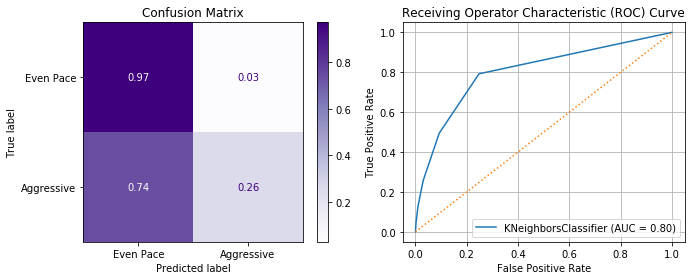

In [81]:
model_evaluation(knn_pipe, X_test_df, y_test, X_train_df,y_train,classes = driver_lables )

Our Initial Model has an accuracy of **89%** however this is not a good criterion to judge whether the model is predicting correctly for our business case because the data set is imbalanced. We have to rely on our recall value which is a metric that quantifies the number of correct positive predictions made out of all  positive predictions that could have been made  and Receiving Operator Characteristic Curve to give a better understanding of how our model is performing with this dataset. For this Base Model, the recall value is **0.26** which is not a good as we would want. However, for this Base model, the ROC Curve is **0.80**, which is okay but not as good as we want. Let's try using a different model to see if that score can be improved. Since we are using K Nearest Neighbors, our 'n_neighbors' parameter can help improve our model performance but choosing the optional neighors. We will fill this "best value" by running a grid search.  

### Improve Model

In [28]:
## Create Params grid for n_neighbors
params = {'n_neighbors':list(range(3,27,2))}
params
## Create a GridSearch using recall as scoring
grid = GridSearchCV(knn_pipe,params,scoring='recall',n_jobs=-1,cv= 3)

In [29]:
## Fit and print best params
grid.fit(X_train_df, y_train)
grid.best_params_
#plot_search_results(grid)

{'n_neighbors': 3}

In [30]:
best_knn = grid.best_estimator_

In [31]:
best_knn.fit(X_train_df,y_train)

KNeighborsClassifier(n_neighbors=3)

TRAINING ACCURACY: 93.38%
TESTING ACCURACY: 88.51%
------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

   Even Pace       0.92      0.96      0.94      6621
  Aggressive       0.51      0.34      0.41       867

    accuracy                           0.89      7488
   macro avg       0.71      0.65      0.67      7488
weighted avg       0.87      0.89      0.88      7488

------------------------------------------------------------




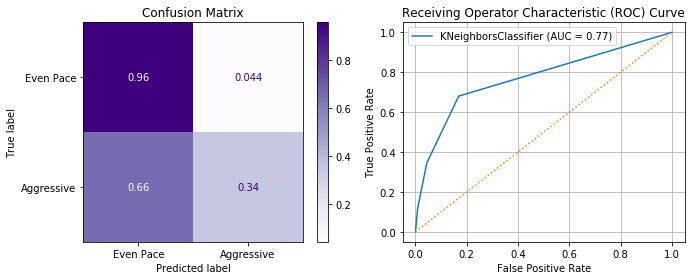

In [82]:
model_evaluation(best_knn, X_test_df,y_test,X_train_df,y_train, classes= driver_lables)

Our revised model has a slight improved recall value of **0.34** which is a little better but not as good as we would want. The ROC Curve drop slightly to **0.77**, which is still pretty good as well. While using the best model parameters we still werent able to imporve our model as much. Let's try using a different model to see if that score can be improved. 

# Random Forests Classifier

Random Forests Classifier is an ensemble tree-based learning algorithm. The Random Forest Classifier is a set of decision trees from randomly selected subset of training set. It aggregates the votes from different decision trees to decide the final class of the test object.

In [34]:
# Inputing the "balanced" parameter will help the model slightly handle the imbalanced dataset

rfc=RandomForestClassifier(class_weight = 'balanced')
rfc.fit(X_train_df, y_train)

RandomForestClassifier(class_weight='balanced')

TRAINING ACCURACY: 100.0%
TESTING ACCURACY: 93.83%
------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

   Even Pace       0.94      0.99      0.97      6621
  Aggressive       0.91      0.52      0.66       867

    accuracy                           0.94      7488
   macro avg       0.93      0.76      0.81      7488
weighted avg       0.94      0.94      0.93      7488

------------------------------------------------------------




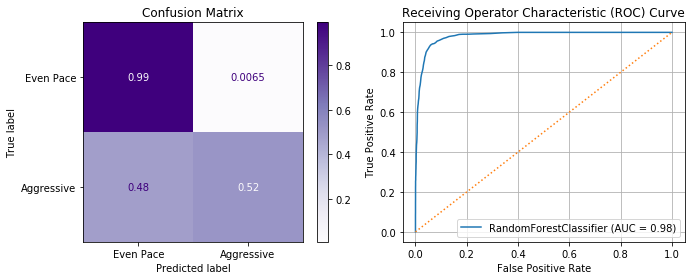

In [83]:
model_evaluation(rfc, X_test_df, y_test,X_train_df, y_train, classes= driver_lables )

Once again the recall value improved to  **0.52** which not as good as we would want. The ROC Curve improved to 0.98 which the higher the value, the better, with a 1.0 giving perfect predictions, which is still pretty good as well. Looks like this imbalnced data set is going to be a problem with these models so I will use SMOTENC to balance the data set. Also the model is over fitted with the training accuracy being 100%.

# SMOTENC

SMOTENC is an oversampling method that helps with imbalanced data sets. The continuous features of the new synthetic minority class sample are created using the same approach of SMOTE as described earlier. The nominal feature is given the value occuring in the majority of the k-nearest neighbors. 

In [37]:
sm = SMOTENC(categorical_features=[15,16,17,18,19], random_state=123, sampling_strategy=.7)
X_trainres, y_trainres = sm.fit_resample(X_train_df, y_train)

In [38]:
from collections import Counter
print("Before SMOTE :" , Counter(y_train))
print("After SMOTE :" , Counter(y_trainres))

Before SMOTE : Counter({0: 15468, 1: 2001})
After SMOTE : Counter({0: 15468, 1: 10827})


In [39]:
rfc_smote=RandomForestClassifier()
rfc_smote.fit(X_trainres, y_trainres)

RandomForestClassifier()

TRAINING ACCURACY: 100.0%
TESTING ACCURACY: 94.86%
------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

   Even Pace       0.97      0.97      0.97      6621
  Aggressive       0.77      0.79      0.78       867

    accuracy                           0.95      7488
   macro avg       0.87      0.88      0.88      7488
weighted avg       0.95      0.95      0.95      7488

------------------------------------------------------------




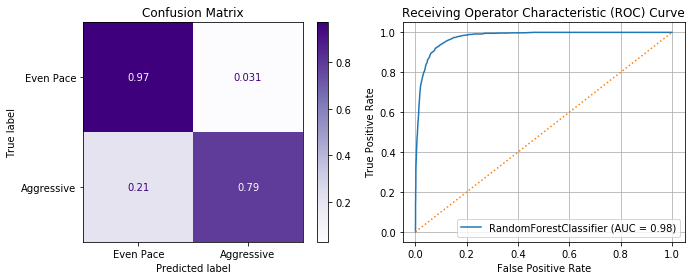

In [84]:
model_evaluation(rfc_smote, X_test_df, y_test,X_train_df, y_train, classes = driver_lables)

Now we are getting somewhere. This really improved the model drastically. Lets now see if we have over fitted the model and what hypertuning we can do to fix that. Training data is over fitted must check hyper parameters.

In [42]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [43]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [44]:
grid = GridSearchCV(rfc_smote,param_grid= param_grid,scoring='recall',n_jobs=-1,cv= 3)
grid.fit(X_trainres, y_trainres)
grid.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 72}

In [45]:
best_rfc_smote = grid.best_estimator_
best_rfc_smote.fit(X_trainres, y_trainres)

RandomForestClassifier(bootstrap=False, max_depth=4, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=72)

TRAINING ACCURACY: 79.22%
TESTING ACCURACY: 74.33%
------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

   Even Pace       0.96      0.74      0.84      6621
  Aggressive       0.27      0.74      0.40       867

    accuracy                           0.74      7488
   macro avg       0.61      0.74      0.62      7488
weighted avg       0.88      0.74      0.79      7488

------------------------------------------------------------




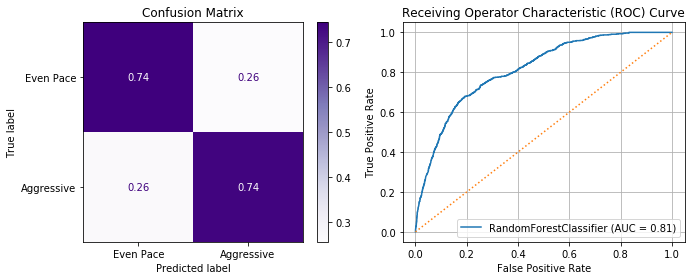

In [85]:
model_evaluation(best_rfc_smote, X_test_df, y_test,X_trainres, y_trainres, classes = driver_lables)

The model is no longer overfitted but we have experrienced a drop in ROC curve  **0.81** and recall values of **0.74** . Random Forest Classifer was an improvement but we will try one more model to see if we can get better accuracy. 

# XGB Boost

In [48]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_trainres,y_trainres)

XGBClassifier()

TRAINING ACCURACY: 86.92%
TESTING ACCURACY: 84.16%
------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

   Even Pace       0.95      0.86      0.91      6621
  Aggressive       0.39      0.68      0.50       867

    accuracy                           0.84      7488
   macro avg       0.67      0.77      0.70      7488
weighted avg       0.89      0.84      0.86      7488

------------------------------------------------------------




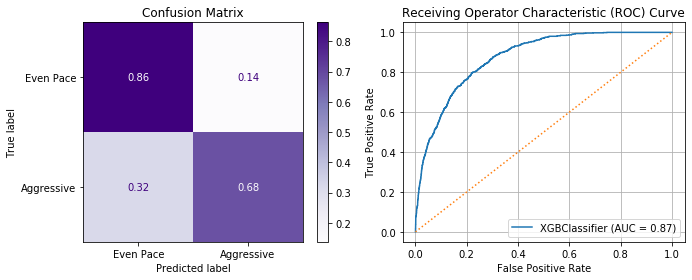

In [86]:
model_evaluation(xgb_clf, X_test_df,y_test,X_trainres, y_trainres, classes = driver_lables)

Not bad for a vanilla XGBoost model but we want to run a Gridsearch for the optimal parameters to improve the model.

In [51]:
#PARAMETERS DICTIONARY FOR GRIDSEARCH
param_grid = {
    "learning_rate": [0.1,0.01],
    'max_depth': [3,6,9],
    'min_child_weight': [1,3,5],
    'subsample': [0.6,0.7,0.8],
    
}

In [52]:
grid = GridSearchCV(xgb_clf,param_grid= param_grid,scoring='recall',n_jobs=-1,cv= 3)
grid.fit(X_trainres, y_trainres)
grid.best_params_

{'learning_rate': 0.01,
 'max_depth': 9,
 'min_child_weight': 1,
 'subsample': 0.7}

In [53]:
sm = SMOTENC(categorical_features=[15,16,17,18,19], random_state=123, sampling_strategy=1)
X_trainres, y_trainres = sm.fit_resample(X_train_df, y_train)

In [54]:
best_xgb_clf = grid.best_estimator_
best_xgb_clf.fit(X_trainres, y_trainres)

XGBClassifier(learning_rate=0.01, max_depth=9, subsample=0.7)

TRAINING ACCURACY: 90.17%
TESTING ACCURACY: 82.05%
------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

   Even Pace       0.97      0.82      0.89      6621
  Aggressive       0.37      0.82      0.51       867

    accuracy                           0.82      7488
   macro avg       0.67      0.82      0.70      7488
weighted avg       0.90      0.82      0.85      7488

------------------------------------------------------------




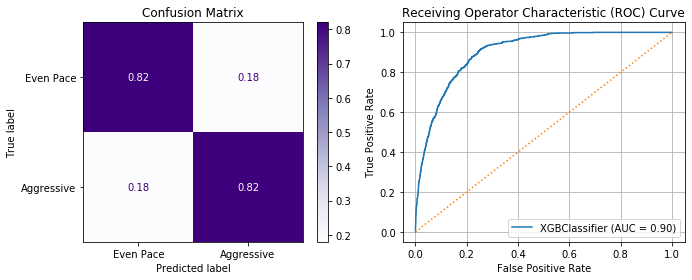

In [87]:
model_evaluation(best_xgb_clf,X_test_df,y_test,X_trainres, y_trainres, classes = driver_lables)

Now that the model has been tuned, lets look at the most important features and what they mean.

# Shap 

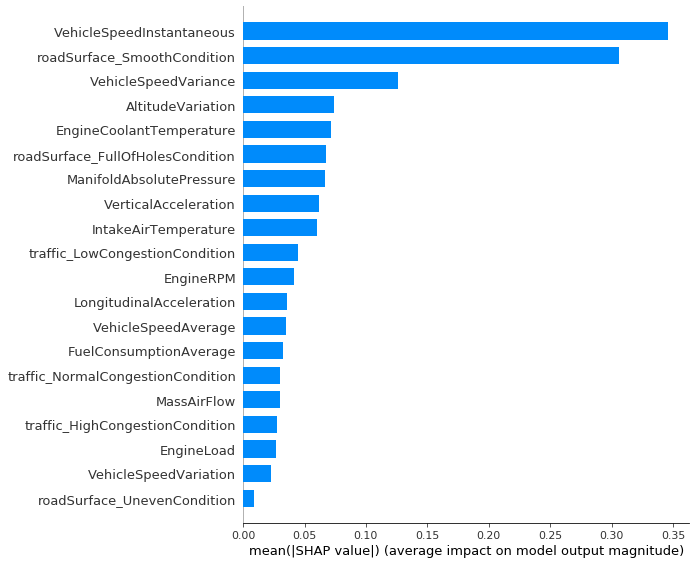

In [57]:
#Calling the Shap Tree Explainer
explainer = shap.TreeExplainer(best_xgb_clf)

#Getting Shap values
shap_values = explainer.shap_values(X_trainres)

#Plotting Most important features
shap.summary_plot(shap_values, X_trainres, plot_type="bar")

This plot illustrates the top 20 important features in our model in decending order. The "VehicleSpeedInstantaneous" which stands for Current Speed Value is the feature that was used the most by the XGBoost tree. This graph does not show how each feature values positivily or negativily affect the model. 



Using the shap.summary_plot will show the true relationship of each of the predictors with the target variable. Feature importance variable are ranked in descending order with the original values color coded whether that variable is high (in red) or low (in blue) for visual observations.

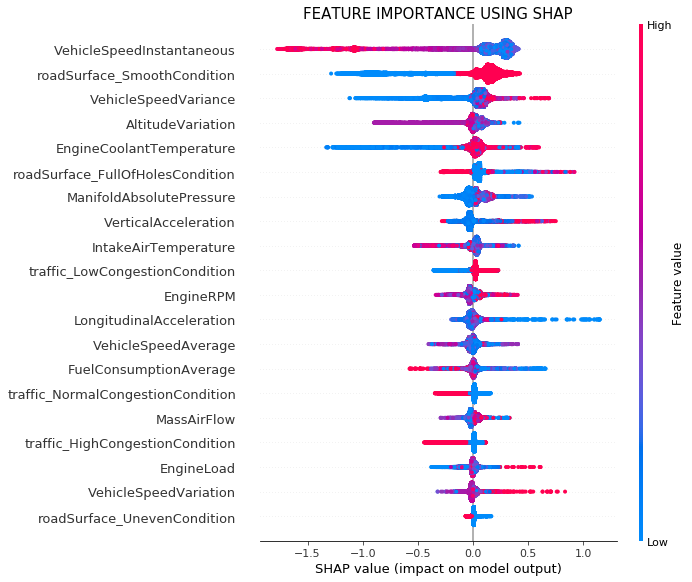

In [58]:
shap.summary_plot(shap_values,X_trainres,show=False)
plt.title('FEATURE IMPORTANCE USING SHAP',fontsize = 15)
plt.show()

Here are some take aways from the plot above.

Things that help predict Aggressive Driving

    * Road Condition (categorical)
    * Engine Load
    * Average Fuel Consumption
    * Vertical and Longitudinal Acceleration
    * Vehicle Speed Variation
    * Vehicle Speed Variance
    * Engine RPM
    




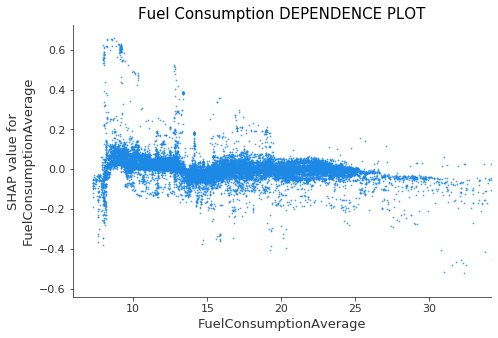

In [96]:
shap.dependence_plot('FuelConsumptionAverage',shap_values,features=X_trainres,xmax="percentile(99)",
                    alpha=0.8,dot_size=3,interaction_index= None ,
                    show=False,)
plt.title('Fuel Consumption DEPENDENCE PLOT',fontsize = 15)
plt.show()

When the Average Fuel Consumption is low the predicted probability is higher while when the fuel consumption is high the predicted probability is lower.

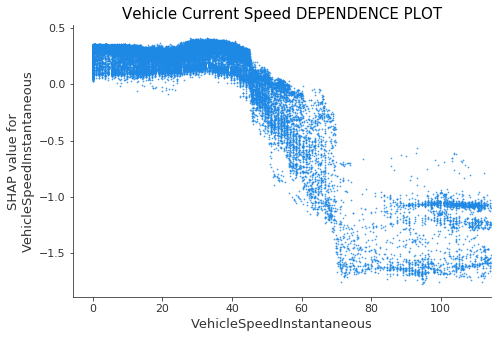

In [94]:
shap.dependence_plot('VehicleSpeedInstantaneous',shap_values,features=X_trainres,xmax="percentile(99)",
                    alpha=0.8,dot_size=3,interaction_index= None ,
                    show=False,)
plt.title('Vehicle Current Speed DEPENDENCE PLOT',fontsize = 15)
plt.show()

Speeds over 60 Mph negatively impacts the model because it becomes hard to tell if the driver is aggressive or not. That would be the thresshold for the model predictions strength but after 60 mph this feature becomes irrelevant. 

# Conclusion and Future Work

## Conclusion

To Summarize, the purpose of building this model was to be able to predict wheter a driver was driving agressive or not. Its intent was to give insurance companies another risk factor to implement in giving out accurate insurance premeiums. Today, most companies just use driving history whether it be lenght of driving history or any previous traffic violation. This gives companies a real time predictor and give the drivers a better scenario to always be able to be a better driver. 

* XGBoost Classifier is the best suitable model for this data with following parameters:{'learning_rate': 0.01, 'max_depth': 9,'min_child_weight': 1,'subsample': 0.7}

* Our model was able to predict Aggrissive driving by a driver 82% of the time which is very impressive do to the very initial imbalanced data set. 

From Analyzing the SHAP summary and dependence plots, the following conclusions were taken.





* When the Average Fuel Consumption is low the predicted probability is higher while when the fuel consumption is high the predicted probability is lower.

* Speeds over 60 Mph negativily impacts the model because it becomes hard to tell if the driver is aggressive or not. That would be the tresshold for the model predictions strength but after 60 mph this feature becomes irrelevant.



## Future Work

*  The improve the models predicting capability i would like to add Age and Gender predictors and she if the will help the models performance. For Example, do younger men tend to drive more aggressively?

* More car attributies should be recorded like Averge Steering Wheel Jerk and Aggressive braking could also be added as a predictor and help make the model better.

* Gather new data from all type of cars. These mini smart cars dont have much aggressive ability. It would be intresting to see diffrent sedans, coupes and trucks involved in the next round of data.

